## Penjelasan Dataset yang digunakan

In [ ]:

# Berikan penjelasan terkait data apa yang digunakan diantaranya:
# 1. Kasus yang diambil
# Dataset ini berisi pesan SMS yang dikategorikan sebagai spam (pesan promosi/penipuan) atau ham (pesan normal).
# Tujuannya: membangun model klasifikasi teks untuk mendeteksi apakah sebuah SMS tergolong spam atau bukan.
# 2. Penjelasan setiap kolomnya
#Biasanya dataset ini memiliki dua kolom utama:
#label → berisi kategori pesan: spam atau ham
#message → isi teks SMS yang akan dianalisis

# 4. Load data

In [ ]:
# 3. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Understanding

In [ ]:
# 1. Jumlah baris data
# 2. Panjang rata-rata setiap baris
# 3. Cek data duplikasi
# 4. Cek data kosong
# 5. Distribusi data menggunakan bar chart, line chart atau word cloud, seperti kata yang sering muncul.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/nlp tugas/spam_sms.csv')
df.columns = ['label', 'message']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# 1. Jumlah baris data
print("Jumlah baris data:", len(df))

Jumlah baris data: 5572


In [ ]:
print("Panjang rata-rata setiap pesan:", df['message'].apply(len).mean())


Panjang rata-rata setiap pesan: 80.11880832735105


In [ ]:
print("Jumlah data duplikat:", df.duplicated().sum())

Jumlah data duplikat: 403


In [ ]:
print("Jumlah data kosong tiap kolom:\n", df.isnull().sum())

Jumlah data kosong tiap kolom:
 label      0
message    0
dtype: int64


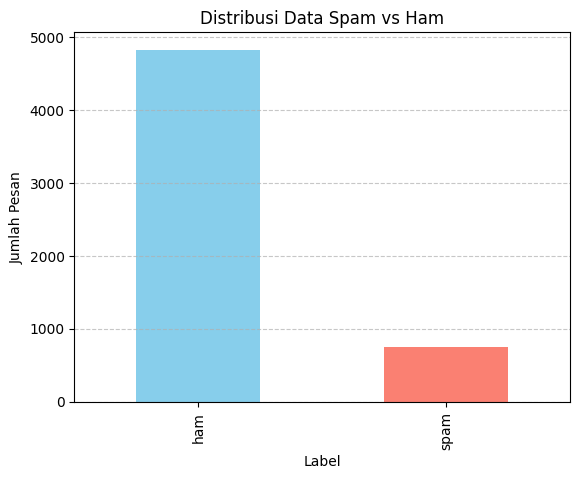

In [ ]:
df['label'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title('Distribusi Data Spam vs Ham')
plt.xlabel('Label')
plt.ylabel('Jumlah Pesan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

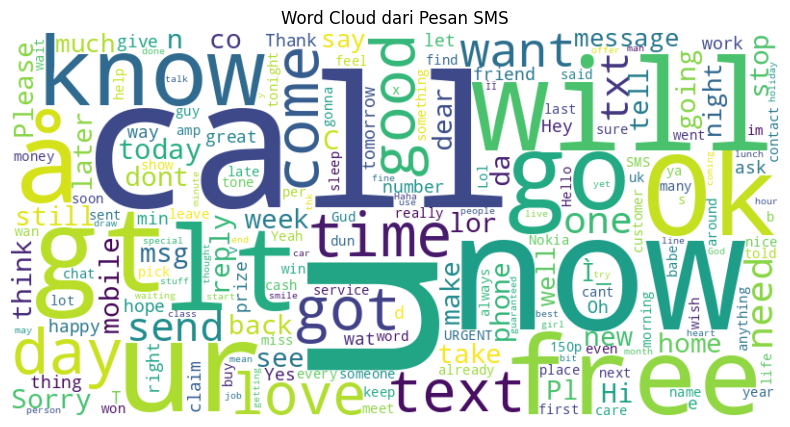

In [ ]:
text = " ".join(df['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Pesan SMS')
plt.show()

## Data Text Processing

In [ ]:
# 1. Tokenisasi
# 2. Lemmatization
# 3. Stemming
# 4. Stopword removal (Tanda baca, angka dan kata)
# 5. Text Normalisasi
# 6. Matrix correlation (opsional)
# 7. Labeling data (Lexicon, Bert, atau polarity)
# 8. Text Vektorisasi
# 9. Data splitting dengan skala (0.8, 02)(0.9, 0.1)(0.75, 0.25)(0.85, 0.15) pilih salah satu dari beberapa skala yang ditentukan
# catatan (lakukan tahap 1- 5 apabila diperlukan, jika tidak langsung ke bagian 6-9)

In [ ]:
def clean_text(text):
    text = text.lower()  # ubah ke huruf kecil
    text = re.sub(r'\d+', '', text)  # hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = text.strip()  # hapus spasi berlebih
    return text

df['clean_text'] = df['message'].apply(clean_text)

In [ ]:
df['tokens'] = df['clean_text'].apply(lambda x: x.split())


In [ ]:
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [ ]:
lemm = WordNetLemmatizer()
df['lemmatized'] = df['tokens'].apply(lambda x: [lemm.lemmatize(word) for word in x])

In [ ]:
df['processed_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))

df[['message', 'processed_text']].head()

,message,processed_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [ ]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [ ]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['processed_text']).toarray()
y = df['label_num']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Ukuran data train:", X_train.shape)
print("Ukuran data test:", X_test.shape)

Ukuran data train: (4457, 3000)
Ukuran data test: (1115, 3000)


## Data Modeling

In [ ]:
# Berikan Penjelasan tentang model yang dipilih (baik machine learning maupun deep learning)
# Disarankan menggunakan deep learning.
# 1. Alasan Pemilihan Deep Learning

# Deep learning dipilih karena bisa menangkap pola dan makna dari teks tanpa perlu proses manual yang rumit.
# Berbeda dengan metode klasik yang cuma menghitung seberapa sering kata muncul, model seperti LSTM bisa memahami konteks dan urutan kata dalam kalimat.

# Contohnya, kalimat “You have won a free gift!” jelas termasuk spam, tapi “Do you want a free gift for your friend?” bukan.
# Dua-duanya punya kata “free gift”, tapi maknanya beda — dan hal kayak gini cuma bisa dipahami model deep learning yang ngerti konteks, bukan sekadar hitungan kata.

## Data Evaluasi

In [ ]:
# 1. Confussion Matrix
# 2. Laporann Klasifikasi (Classification report)

In [ ]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [51]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

70/70 ━━━━━━━━━━━━━━━━━━━━ 502s 6s/step - accuracy: 0.8646 - loss: 0.4021 - val_accuracy: 0.8655 - val_loss: 0.3964
Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 450s 6s/step - accuracy: 0.8760 - loss: 0.3805 - val_accuracy: 0.8655 - val_loss: 0.3954
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 450s 6s/step - accuracy: 0.8669 - loss: 0.3968 - val_accuracy: 0.8655 - val_loss: 0.3949
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 448s 6s/step - accuracy: 0.8712 - loss: 0.3892 - val_accuracy: 0.8655 - val_loss: 0.3965
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 447s 6s/step - accuracy: 0.8745 - loss: 0.3819 - val_accuracy: 0.8655 - val_loss: 0.3952
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 439s 6s/step - accuracy: 0.8609 - loss: 0.4080 - val_accuracy: 0.8655 - val_loss: 0.3949


In [52]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")


35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 794ms/step


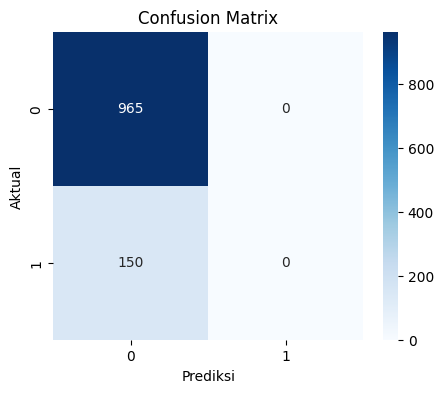

In [53]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Laporan Klasifikasi:
              precision    recall  f1-score   support

         Ham       0.87      1.00      0.93       965
        Spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Gunakan line chart atau barchart untuk perbandingannya

In [55]:
report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'], output_dict=True)
df_report = pd.DataFrame(report).transpose()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


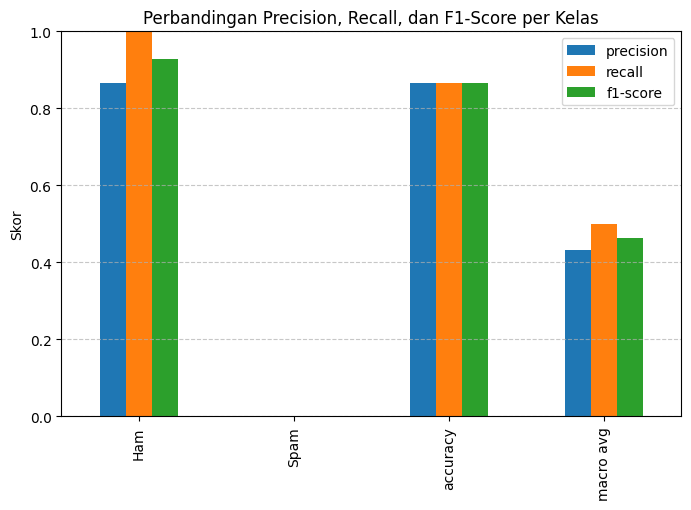

In [56]:
df_report.iloc[:-1, :-1].plot(kind='bar', figsize=(8,5))
plt.title('Perbandingan Precision, Recall, dan F1-Score per Kelas')
plt.ylabel('Skor')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

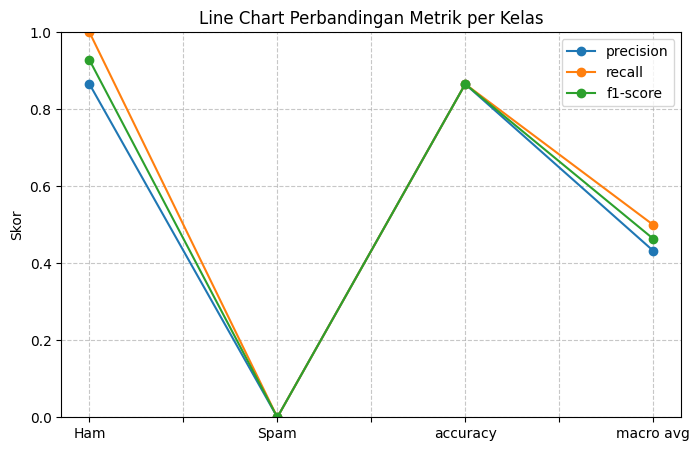

In [57]:
df_report.iloc[:-1, :-1].plot(kind='line', marker='o', figsize=(8,5))
plt.title('Line Chart Perbandingan Metrik per Kelas')
plt.ylabel('Skor')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()